In [1]:
# ─────────────────────────────────────────────────────────────────────────────
# 05_benchmarks.ipynb
# ─────────────────────────────────────────────────────────────────────────────

# 0) Ensure src/ is on PYTHONPATH, and import necessary pieces
%run setup.py

import time
import numpy as np
import pandas as pd
import torch
from pathlib import Path

from sklearn.metrics import (
    log_loss,
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
)
from src.pretrained_models import default_experts, MoEClassifier
from src.logs import log_event, LogKind

# ─────────────────────────────────────────────────────────────────────────────
# 1) Find all “moe_<key>_idxs.npy” under models/gates/ and pair with
#    the matching “gate_<key>_retrained.pt”
# ─────────────────────────────────────────────────────────────────────────────
gate_dir = Path("../models/gates")
idx_files = sorted(gate_dir.glob("moe_*_idxs.npy"))

if not idx_files:
    raise RuntimeError(f"No ‘moe_<key>_idxs.npy’ files found in {gate_dir}.")

# Build a list of (key, idx_path, gate_path) tuples
top_runs = []
for idx_path in idx_files:
    stem = idx_path.stem  # e.g. "moe_LRFeatureExpert+XGBFeatureExpert_idxs"
    if not stem.startswith("moe_") or not stem.endswith("_idxs"):
        continue
    key = stem[len("moe_") : -len("_idxs")]  # e.g. "LRFeatureExpert+XGBFeatureExpert"
    gate_path = gate_dir / f"gate_{key}_retrained.pt"
    if not gate_path.exists():
        continue  # skip if no matching .pt
    top_runs.append((key, idx_path, gate_path))

if not top_runs:
    raise RuntimeError(f"No matching ‘gate_<key>_retrained.pt’ found under {gate_dir}.")

print(f"Found {len(top_runs)} gate checkpoints:")
for key, idx_path, gate_path in top_runs:
    print(f"  * key = {key!r}, idxs = {idx_path.name}, gate = {gate_path.name}")

# ─────────────────────────────────────────────────────────────────────────────
# 2) Prepare the TEST split once
# ─────────────────────────────────────────────────────────────────────────────
test_df = pd.read_csv("../data/splits/test.csv").dropna(subset=["question1", "question2"])
pairs_test = list(zip(test_df.question1, test_df.question2))
y_test = test_df.is_duplicate.values.astype(int)

# ─────────────────────────────────────────────────────────────────────────────
# 3) Evaluate each “top” run on TEST, collecting & logging metrics one by one
# ─────────────────────────────────────────────────────────────────────────────

import time
import numpy as np
import torch
from sklearn.metrics import (
    log_loss,
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
)
from src.pretrained_models import default_experts, MoEClassifier
from src.logs import log_event, LogKind

# ensure we have a GPU if available
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# paths to your embeddings and Distil‐BERT LR head
emb_path_768 = "../data/processed/question_embeddings_768.npy"
lr_path      = "../models/pretrained/quoradistil_lr.pkl"

# factory map from class‐name to zero‐arg constructor
from src.pretrained_models import BertExpert, RobertaExpert, XLNetExpert, QuoraDistilExpert, CrossEncExpert
from src.custom_models      import LRFeatureExpert, XGBFeatureExpert, LGBMFeatureExpert, KNNFeatureExpert, RFFeatureExpert, SVMFeatureExpert

factories = {
    "BertExpert":    lambda: BertExpert(),
    "RobertaExpert": lambda: RobertaExpert(),
    "XLNetExpert":   lambda: XLNetExpert(),
    "QuoraDistilExpert": lambda: QuoraDistilExpert(
        emb_path=emb_path_768,
        lr_path=lr_path
    ),
    "CrossEncExpert":    lambda: CrossEncExpert(),
    "LRFeatureExpert":   lambda: LRFeatureExpert(dim=384),
    "XGBFeatureExpert":  lambda: XGBFeatureExpert(dim=384),
    "LGBMFeatureExpert": lambda: LGBMFeatureExpert(dim=384),
    "KNNFeatureExpert":  lambda: KNNFeatureExpert(dim=384),
    "RFFeatureExpert":   lambda: RFFeatureExpert(dim=384),
    "SVMFeatureExpert":  lambda: SVMFeatureExpert(dim=384),
}

for key, idx_path, gate_path in top_runs:
    print(f"\n=== Evaluating gate `{key}` on TEST ===")
    idxs = np.load(idx_path).tolist()

    # build exactly the experts needed, one by one
    experts = [factories[name]() for name in key.split("+")]

    # instantiate the MoE; we pass lr=1.0 and epochs=0 as placeholders 
    # since we aren't (re)training the gate here—just loading it.
    moe = MoEClassifier(experts, lr=1.0, epochs=0)

    # move gate to DEVICE before loading weights
    moe.gate.to(DEVICE)

    # load the state dict directly onto GPU
    state_dict = torch.load(gate_path, map_location=DEVICE)
    moe.gate.load_state_dict(state_dict)
    moe.gate.eval()

    # run inference
    t0 = time.time()
    probs = moe.predict_prob(pairs_test)
    inference_time = time.time() - t0
    preds = (probs > 0.5).astype(int)

    # compute metrics
    ll   = log_loss(y_test, probs)
    acc  = accuracy_score(y_test, preds)
    f1   = f1_score(y_test, preds)
    prec = precision_score(y_test, preds)
    rec  = recall_score(y_test, preds)
    try:
        auc = roc_auc_score(y_test, probs)
    except ValueError:
        auc = float("nan")

    # print results
    print(f"  log-loss: {ll:.4f}   acc: {acc:.4f}   f1: {f1:.4f}   auc: {auc:.4f}")
    print(f"  inference time: {inference_time:.2f}s")

    # log them
    log_event(
        LogKind.TEST,
        model=key,
        phase="eval",
        seconds=round(inference_time, 2),
        test_LL=round(ll, 6),
        test_ACC=round(acc, 4),
        test_F1=round(f1, 4),
        test_PREC=round(prec, 4),
        test_REC=round(rec, 4),
        test_AUC=round(auc, 4),
    )

    # free GPU memory
    del moe
    for exp in experts:
        if hasattr(exp, "_model"):
            try: exp._model.cpu()
            except: pass
            exp._model = None
        if hasattr(exp, "_tokenizer"):
            exp._tokenizer = None
        del exp
    torch.cuda.empty_cache()
    import gc; gc.collect()

Found 10 gate checkpoints:
  * key = 'BertExpert+RobertaExpert+CrossEncExpert+LRFeatureExpert', idxs = moe_BertExpert+RobertaExpert+CrossEncExpert+LRFeatureExpert_idxs.npy, gate = gate_BertExpert+RobertaExpert+CrossEncExpert+LRFeatureExpert_retrained.pt
  * key = 'BertExpert+RobertaExpert+CrossEncExpert+SVMFeatureExpert', idxs = moe_BertExpert+RobertaExpert+CrossEncExpert+SVMFeatureExpert_idxs.npy, gate = gate_BertExpert+RobertaExpert+CrossEncExpert+SVMFeatureExpert_retrained.pt
  * key = 'BertExpert+RobertaExpert+CrossEncExpert+XGBFeatureExpert', idxs = moe_BertExpert+RobertaExpert+CrossEncExpert+XGBFeatureExpert_idxs.npy, gate = gate_BertExpert+RobertaExpert+CrossEncExpert+XGBFeatureExpert_retrained.pt
  * key = 'BertExpert+RobertaExpert+CrossEncExpert', idxs = moe_BertExpert+RobertaExpert+CrossEncExpert_idxs.npy, gate = gate_BertExpert+RobertaExpert+CrossEncExpert_retrained.pt
  * key = 'BertExpert+RobertaExpert+LGBMFeatureExpert', idxs = moe_BertExpert+RobertaExpert+LGBMFeatureExpe

/home/lazar/.venvs/data-science/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


  log-loss: 0.0407   acc: 0.9902   f1: 0.9868   auc: 0.9980
  inference time: 215.66s

=== Evaluating gate `BertExpert+RobertaExpert+QuoraDistilExpert+CrossEncExpert+LRFeatureExpert+LGBMFeatureExpert+SVMFeatureExpert` on TEST ===


/home/lazar/.venvs/data-science/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


  log-loss: 0.0395   acc: 0.9902   f1: 0.9868   auc: 0.9980
  inference time: 485.51s

=== Evaluating gate `BertExpert+RobertaExpert+QuoraDistilExpert+CrossEncExpert+LRFeatureExpert+LGBMFeatureExpert` on TEST ===


/home/lazar/.venvs/data-science/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


  log-loss: 0.0394   acc: 0.9902   f1: 0.9868   auc: 0.9980
  inference time: 390.16s

=== Evaluating gate `BertExpert+RobertaExpert+QuoraDistilExpert+CrossEncExpert+LRFeatureExpert+XGBFeatureExpert+LGBMFeatureExpert+SVMFeatureExpert` on TEST ===


/home/lazar/.venvs/data-science/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


  log-loss: 0.0394   acc: 0.9902   f1: 0.9868   auc: 0.9980
  inference time: 550.71s

=== Evaluating gate `BertExpert+RobertaExpert+QuoraDistilExpert+CrossEncExpert+LRFeatureExpert` on TEST ===
  log-loss: 0.0396   acc: 0.9902   f1: 0.9868   auc: 0.9980
  inference time: 303.98s

=== Evaluating gate `BertExpert+RobertaExpert` on TEST ===
  log-loss: 0.0393   acc: 0.9902   f1: 0.9869   auc: 0.9981
  inference time: 125.59s


        seconds  test_LL  test_ACC  test_F1  test_PREC  test_REC  test_AUC
count   10.0000  10.0000   10.0000  10.0000    10.0000   10.0000   10.0000
mean   320.0030   0.0395    0.9902   0.9868     0.9839    0.9898    0.9981
std    127.4470   0.0006    0.0000   0.0000     0.0000    0.0000    0.0001
min    125.5900   0.0383    0.9902   0.9868     0.9839    0.9898    0.9980
25%    237.5350   0.0393    0.9902   0.9868     0.9839    0.9898    0.9980
50%    304.2300   0.0395    0.9902   0.9868     0.9839    0.9898    0.9980
75%    368.9975   0.0396    0.9902   0.9868     0.9839    0.9898    0.9982
max    550.7100   0.0407    0.9902   0.9869     0.9839    0.9898    0.9982


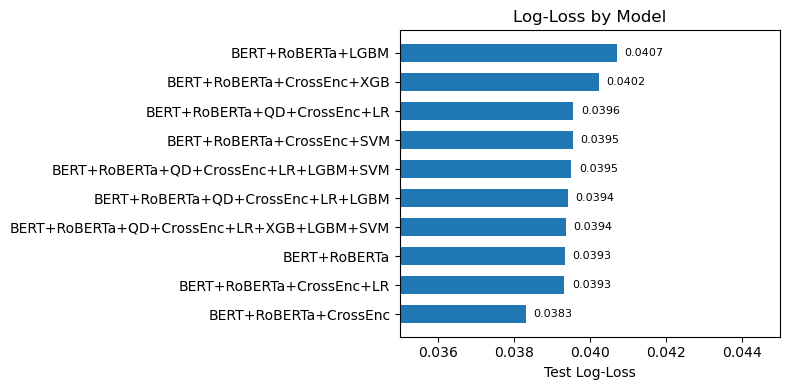

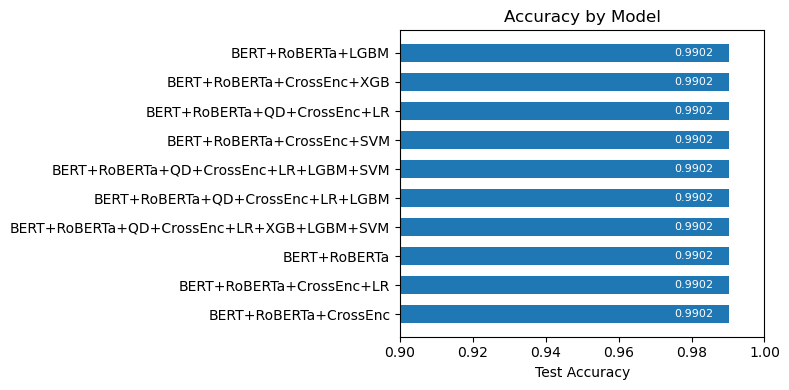

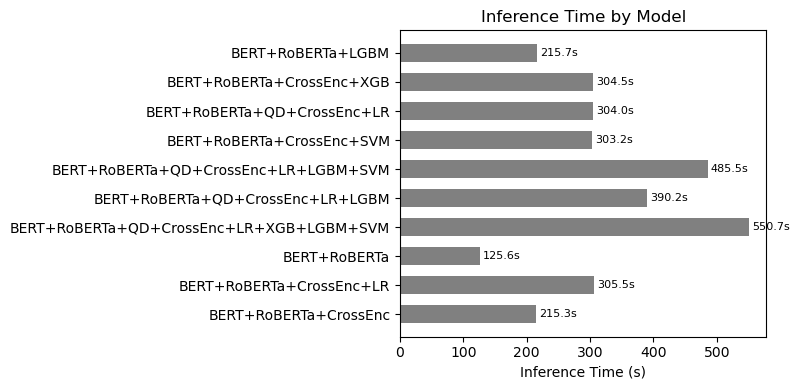

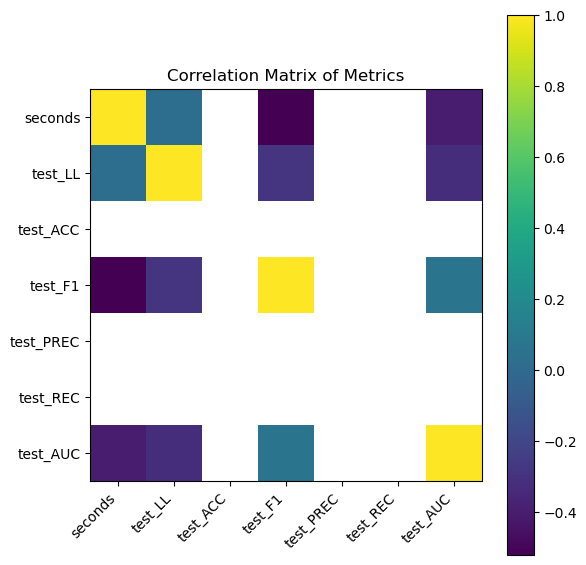

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# ─────────────────────────────────────────────────────────────────────────────
# 1) Parse the raw log lines into a DataFrame
# ─────────────────────────────────────────────────────────────────────────────
records = []
with open("../metric_logs/benchmarks.csv", "r", encoding="utf8") as f:
    for line in f:
        line = line.strip()
        if not line:
            continue
        parts = line.split(",")
        rec = {}
        # timestamp, caller
        rec["timestamp"] = parts[0]
        rec["caller"]    = parts[1].strip("<>")
        # remaining k=v
        for kv in parts[2:]:
            if "=" not in kv:
                continue
            k, v = kv.split("=", 1)
            if k in {"seconds","test_LL","test_ACC","test_F1","test_PREC","test_REC","test_AUC"}:
                rec[k] = float(v)
            else:
                rec[k] = v
        records.append(rec)

df = pd.DataFrame(records).dropna(subset=["model","test_LL","test_ACC"])

# ─────────────────────────────────────────────────────────────────────────────
# 2) Shorten model names
# ─────────────────────────────────────────────────────────────────────────────
abbr = {
    "BertExpert":        "BERT",
    "RobertaExpert":     "RoBERTa",
    "XLNetExpert":       "XLNet",
    "QuoraDistilExpert": "QD",
    "CrossEncExpert":    "CrossEnc",
    "LRFeatureExpert":   "LR",
    "XGBFeatureExpert":  "XGB",
    "LGBMFeatureExpert": "LGBM",
    "KNNFeatureExpert":  "KNN",
    "RFFeatureExpert":   "RF",
    "SVMFeatureExpert":  "SVM",
}
def short(name):
    return "+".join(abbr.get(p,p) for p in name.split("+"))

df["short"] = df["model"].apply(short)
df = df.sort_values("test_LL").reset_index(drop=True)

# ─────────────────────────────────────────────────────────────────────────────
# 3) Summary statistics
# ─────────────────────────────────────────────────────────────────────────────
print(df[["seconds","test_LL","test_ACC","test_F1","test_PREC","test_REC","test_AUC"]]
      .describe().round(4))

# ─────────────────────────────────────────────────────────────────────────────
# 4) Bar chart: Test Log-Loss by Model
# ─────────────────────────────────────────────────────────────────────────────
plt.figure(figsize=(8, 4))
y = np.arange(len(df))
plt.barh(y, df["test_LL"], height=0.6)
plt.yticks(y, df["short"])
plt.xlabel("Test Log-Loss")
plt.title("Log-Loss by Model")
plt.xlim(0.035, 0.045)
# annotate
for i, v in enumerate(df["test_LL"]):
    plt.text(v + 0.0002, i, f"{v:.4f}", va="center", fontsize=8)
plt.tight_layout()
plt.show()

# ─────────────────────────────────────────────────────────────────────────────
# 5) Bar chart: Test Accuracy by Model
# ─────────────────────────────────────────────────────────────────────────────
plt.figure(figsize=(8, 4))
plt.barh(y, df["test_ACC"], height=0.6)
plt.yticks(y, df["short"])
plt.xlabel("Test Accuracy")
plt.title("Accuracy by Model")
plt.xlim(0.90, 1.00)
for i, v in enumerate(df["test_ACC"]):
    plt.text(v - 0.015, i, f"{v:.4f}", va="center", fontsize=8, color="white")
plt.tight_layout()
plt.show()

# ─────────────────────────────────────────────────────────────────────────────
# 6) Bar chart: Inference Time by Model
# ─────────────────────────────────────────────────────────────────────────────
plt.figure(figsize=(8, 4))
plt.barh(y, df["seconds"], height=0.6, color="gray")
plt.yticks(y, df["short"])
plt.xlabel("Inference Time (s)")
plt.title("Inference Time by Model")
for i, v in enumerate(df["seconds"]):
    plt.text(v + 5, i, f"{v:.1f}s", va="center", fontsize=8)
plt.tight_layout()
plt.show()

# ─────────────────────────────────────────────────────────────────────────────
# 7) Correlation matrix heatmap
# ─────────────────────────────────────────────────────────────────────────────
metrics = ["seconds","test_LL","test_ACC","test_F1","test_PREC","test_REC","test_AUC"]
corr = df[metrics].corr("spearman")
plt.figure(figsize=(6, 6))
plt.imshow(corr, cmap="viridis", interpolation="none")
plt.colorbar()
plt.xticks(range(len(metrics)), metrics, rotation=45, ha="right")
plt.yticks(range(len(metrics)), metrics)
plt.title("Correlation Matrix of Metrics")
plt.tight_layout()
plt.show()